<a href="https://colab.research.google.com/github/VolkhinD/Steel/blob/main/Steel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Semantic Segmentation for Steel Surface Defect Classification***

https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/

https://www.v7labs.com/blog/image-segmentation-guide#h5


# **Representing the task**


**Description:**

- In this project, I aim to develop a state-of-the-art semantic segmentation neural network to address the critical task of localizing and classifying surface defects on steel sheets. [The dataset](https://www.kaggle.com/competitions/severstal-steel-defect-detection/overview), comprising 5506 unique images sourced from Kaggle, represents diverse instances of steel surfaces with varying defect scenarios.

**Objectives**

**Localization and Classification:**
- Implement a neural network capable of accurately localizing and classifying surface defects on steel sheets.
The defects fall into multiple classes [0, 1, 2, 3, 4], with 0 representing the background class.

**Dataset Overview:**
- The dataset contains RGB color images (*heigh $\times$ width $\times$ 3*).
 Masks are represented as a string with pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

 The dataset encompasses a wide range of scenarios, including images with no defects, single-class defects, and instances with multiple defect classes.

**Semantic Segmentation:**
- Employ advanced semantic segmentation techniques to precisely segment defects for each class within every image.

Example of semantic segmentation
![E](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-17-at-9.02.15-PM.png)

**Evaluation and Metrics:**
- I use custom Intersection over Union (IoU) Metric to evaluate model performance.
It can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

 $\Large\frac{|X\cap Y|}{|X| + |Y| - |X\cap Y|}$



**Robustness and Generalization:**
- Ensure the developed model's robustness by validating its performance on diverse images, including those not present in the training set.
Aim for a solution that generalizes well to unseen defect patterns.

**Tool and Libraries**
- ***Segmentation_models_pytorch*** is an awesome library built on the PyTorch framework, which is used to create a PyTorch nn.Module (with just two lines of code) for image segmentation tasks. I take pretrained U-Net and train it for 50 epoches.
U-Net <sup id="a2">[2](#f2)</sup>
![U-Net](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61252d8c305c0b579b0dbc60_u-net.png)
- For image augmentations I use ***Albumentations*** library that changes images and masks at the same time.

**Expected Outcome:**
- The project's successful completion will result in a robust and accurate semantic segmentation model capable of localizing and classifying surface defects on steel sheets.

# Imports and EDA of dataset

In [2]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image
import random
import torch
import torch.optim as optim
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F
import albumentations as A
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.autograd.profiler as profiler


In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(16)

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data/Steel/train.csv')
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
data.ClassId.unique()

array([1, 3, 4, 2])

<Axes: title={'center': 'Number of Classes'}, xlabel='class', ylabel='number of images'>

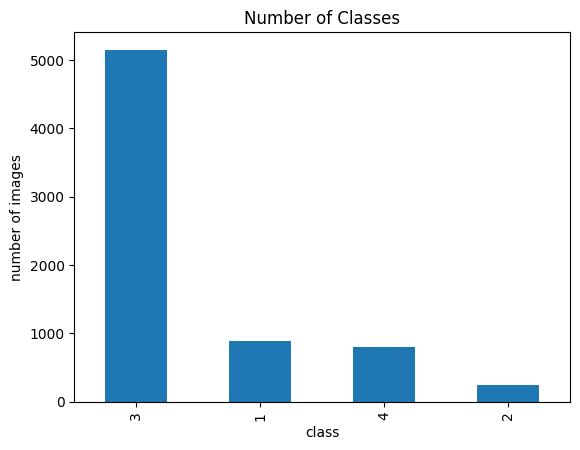

In [5]:
data.ClassId.value_counts().plot.bar(title='Number of Classes', xlabel='class', ylabel='number of images')

Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image you must segment defects of each class (ClassId = [1, 2, 3, 4]).

ADD CLASS WEIGHTS!

In [6]:
print("Number of Images in a folder is mare than 12500")
print(f"Number of pictures with at least 1 defect is {len(data.ImageId.unique())}")
print('Almost a half of images is empty')

Number of Images in a folder is mare than 12500
Number of pictures with at least 1 defect is 6666
Almost a half of images is empty


Some examples have not only one type of defects, but many. Not more than 3

In [7]:
data.ImageId.value_counts()[:5]

ef24da2ba.jpg    3
db4867ee8.jpg    3
84865746c.jpg    2
5665ada1b.jpg    2
eb44ad79d.jpg    2
Name: ImageId, dtype: int64

In [8]:
n1 = (data.ImageId.value_counts() == 1).sum()
n2 = (data.ImageId.value_counts() == 2).sum()
n3 = (data.ImageId.value_counts() == 3).sum()
print(f"Number of images with 3 types of defects is {n3}")
print(f"Number of images with 2 types of defects is {n2}")
print(f"Number of images that have only one defect is {n1}")

Number of images with 3 types of defects is 2
Number of images with 2 types of defects is 425
Number of images that have only one defect is 6239


# Configurations

In [45]:
IMG_SIZE = (256, 1600)
BATCH_SIZE = 8
ENCODER = "resnet34"
ACTIVATION = 'softmax'
CLASSES = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.01
EPOCHES = 20
WEIGHTS = 'imagenet'

# Create Masks

In [10]:
""" Copied from Kaggle"""
def rle2mask(rle, imgshape):

  """ Creates mask for only one type of deffect """

  width = imgshape[0]
  height= imgshape[1]

  mask = np.zeros( width*height ).astype(np.uint8)

  array = np.asarray([int(x) for x in rle.split()])
  starts = array[0::2]
  lengths = array[1::2]

  for index, start in enumerate(starts):
      mask[int(start):int(start+lengths[index])] = 1


  return np.flipud(np.rot90( mask.reshape(height, width), k=1))

In [11]:
def rle_2D_mask(idx, imgshape):

  """Creates mask for all types of defects"""

  width = imgshape[0]
  height= imgshape[1]
  img_name = data.iloc[idx].ImageId
  all_img = data.groupby('ImageId').get_group(img_name)

  mask = np.zeros(width*height).astype(np.uint8)

  if all_img.EncodedPixels.isnull().any(): # any because I plan to add img with no defects so they have only 'ImageId'
    return mask.reshape(width, height)

  for class_id, rle in zip(all_img.ClassId.to_numpy(), all_img.EncodedPixels.to_numpy()):
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = class_id


  return np.flipud(np.rot90(mask.reshape(height, width), k=1))

# Show some example

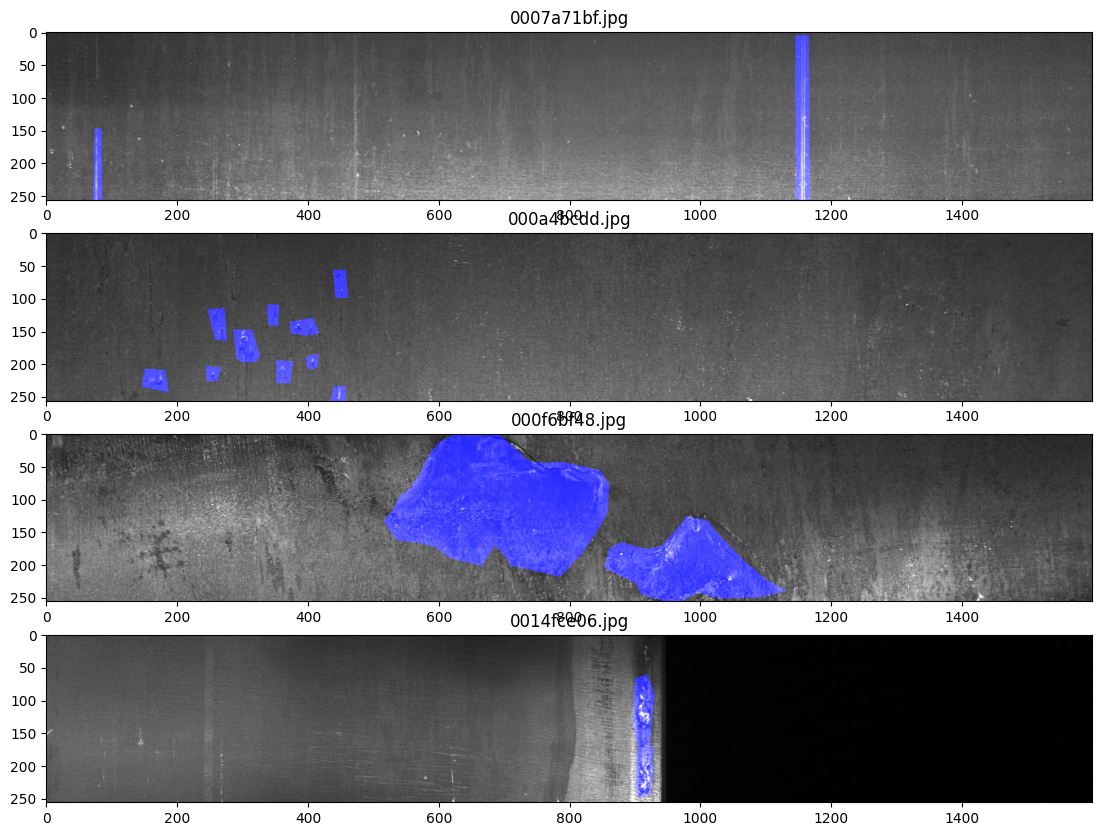

In [12]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
path = '/content/drive/MyDrive/Data/Steel/train/'
for i in range(1, columns*rows+1):
    fn = data['ImageId'].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread(path + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(data['EncodedPixels'].iloc[i], IMG_SIZE)
    img[mask==1,2] = 255
    plt.imshow(img)
plt.show()

Some images have more than 1 defects

In [13]:
data.groupby('ImageId').get_group('db4867ee8.jpg')

,ImageId,ClassId,EncodedPixels
6101,db4867ee8.jpg,1,349941 2 350194 6 350447 11 350700 15 350953 1...
6102,db4867ee8.jpg,2,354411 17 354634 50 354857 82 355096 99 355351...
6103,db4867ee8.jpg,3,233729 3008 236801 64


Example of one image that has 3 types of deffects

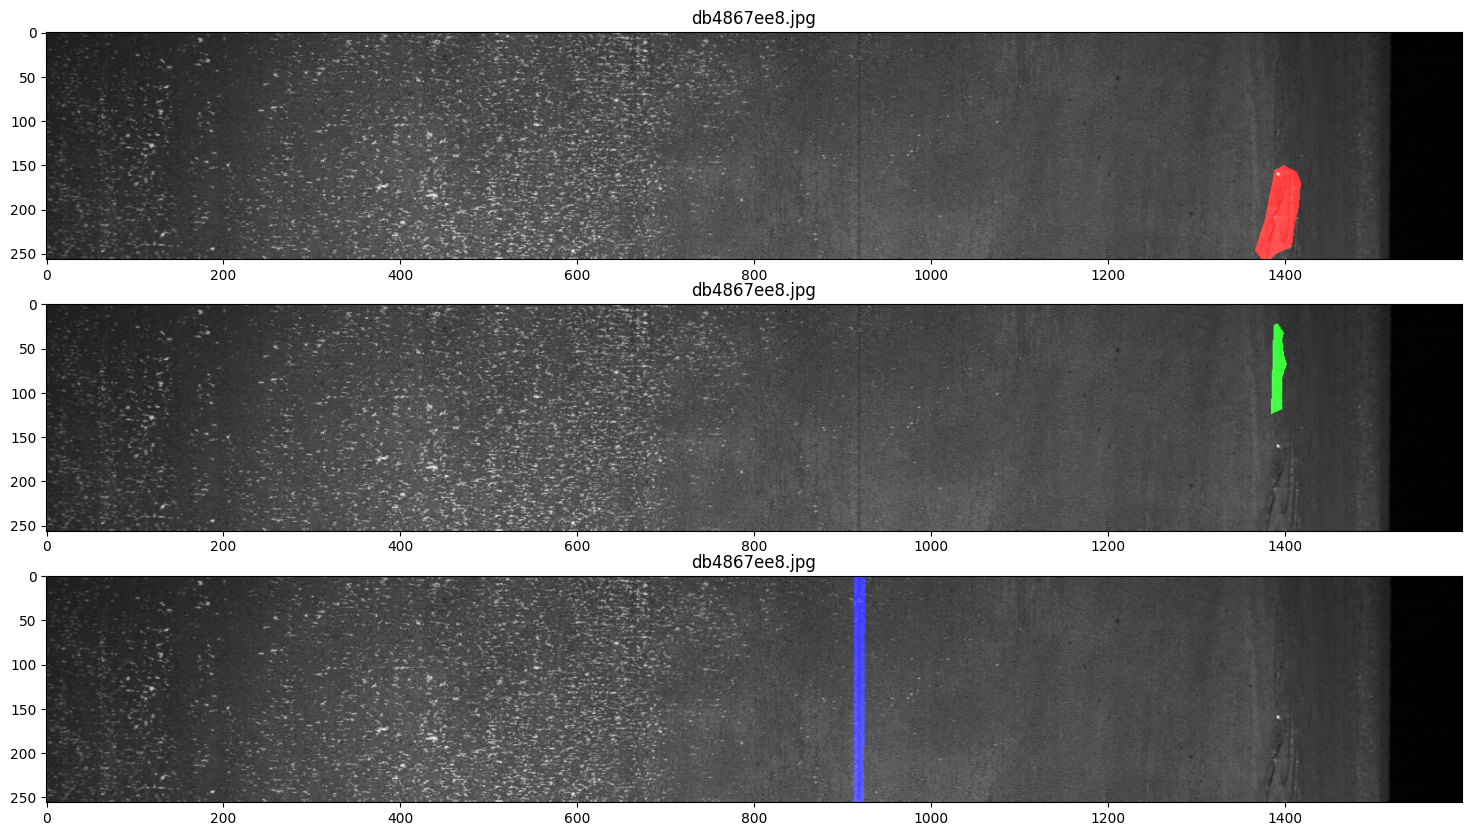

In [14]:
fig = plt.figure(figsize=(20,10))
for i in range(1,4):
    ind = 6100 + i
    fn = data['ImageId'].iloc[ind]
    fig.add_subplot(3, 1, i).set_title(fn)
    img = cv2.imread(path+fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(data['EncodedPixels'].iloc[ind], IMG_SIZE)
    img[mask==1, i - 1] = 255
    plt.imshow(img)
plt.show()

In [15]:
orig_shape = img.shape

For the same case just check if function rle_2D_mask works correctly

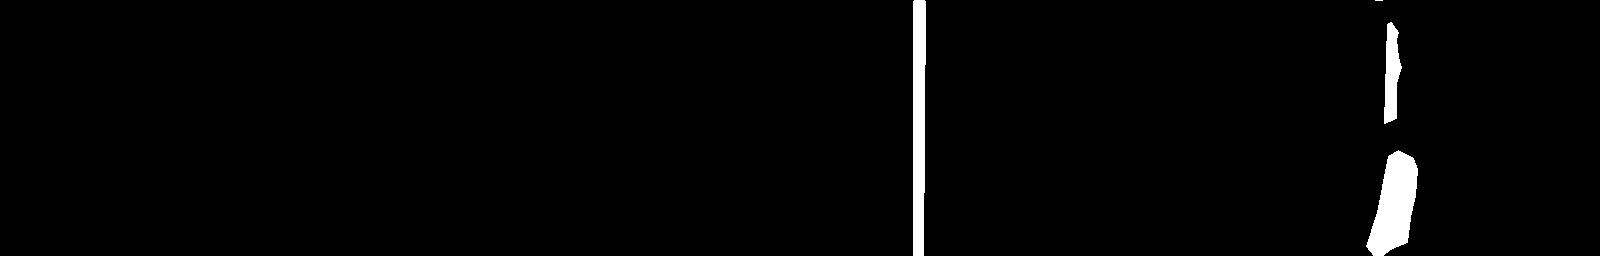

In [16]:
a =  rle_2D_mask(6101, IMG_SIZE)
example_mask = np.where(a > 0, 255 , a)
ex = Image.fromarray(example_mask)
ex

it does)))

# Augmentations

I change image proportion since originals have ratio over 1:6

In [17]:
def get_train_aug():
  return A.Compose([
      A.Resize(IMG_SIZE[0], 2*IMG_SIZE[0]),
      A.VerticalFlip(0.5)], is_check_shapes=False
      )
def get_valid_aug():
  return A.Compose([
      A.Resize(IMG_SIZE[0], 2*IMG_SIZE[0])
  ], is_check_shapes=False)

# Create Custom Dataset

In [18]:
class SteelDataset(Dataset):

  def __init__(self, df, augmentations, example=False):
    self.df = df.reset_index()
    self.augmentations = augmentations
    self.example = example

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx].ImageId
    img_path = '/content/drive/MyDrive/Data/Steel/train/' + img_name

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = rle_2D_mask(idx, IMG_SIZE)
     # to make mask (h, w, c) where c = 1
    mask = np.expand_dims(mask, axis=-1)
    num_obj = np.unique(mask) # return sorted list like [0, 1, 2]

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # from (h, w, c) change to (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.from_numpy(mask)
    if not self.example:
      mask = mask.to(torch.long) # remove it to see mask


    # labels = torch.tensor(num_obj)


    return image, mask



In [19]:
ex = SteelDataset(data, get_train_aug(), True)
ex = ex[1]

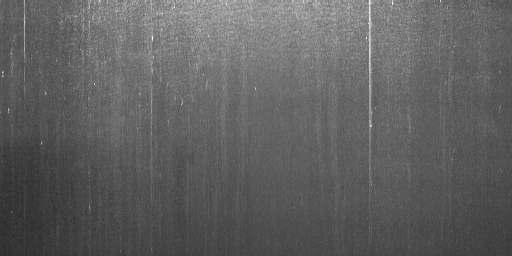

In [20]:
import torchvision.transforms as T
transform = T.ToPILImage()
img = transform(ex[0])
img

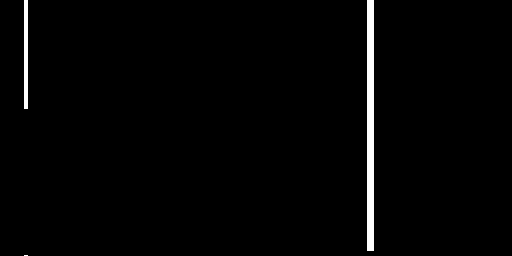

In [21]:
m = transform(ex[1])
m

In [22]:
train_df, valid_df = train_test_split(data, shuffle=True, random_state=0)

In [23]:
train_set = SteelDataset(train_df, get_train_aug())
valid_set = SteelDataset(valid_df, get_valid_aug())

# Load dataset into batches

In [24]:
print(f"Total number of images in train dataset is {train_df.shape[0]}")
print(f"Total number of images in valid dataset is {valid_df.shape[0]}")

Total number of images in train dataset is 5321
Total number of images in valid dataset is 1774


In [25]:
trainloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE)

In [26]:
print(f"Total number of batches in train loader is {len(trainloader)}")
print(f"Total number of batches in validation loader is {len(validloader)}")

Total number of batches in train loader is 666
Total number of batches in validation loader is 222


In [27]:
images, masks = next(iter(trainloader))
print(f"One image Batch shape is {images.size()}")
print(f"One mask batch shape is {masks.size()}")

One image Batch shape is torch.Size([8, 3, 256, 512])
One mask batch shape is torch.Size([8, 1, 256, 512])


In [ ]:
input_grid = torchvision.utils.make_grid(images, nrow=4)
t2img = T.ToPILImage()
t2img(input_grid)

In [ ]:
targets_grid = torchvision.utils.make_grid(masks / 2, nrow=4)
t2img(targets_grid)

# Create Segmentation Model



In [30]:
class SteelUNet(nn.Module):

  def __init__(self):
    super(SteelUNet, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels = 3,
        classes = 5,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='multiclass')(logits, masks)

      return logits, loss1

    return logits

In [31]:
model =  SteelUNet()
model = model.to(DEVICE)

# IoU Metric

Take IoUMetric code here <sup id="a3">[3](#f3)</sup>




In [32]:
def IoUMetric(pred, mask, softmax=False):

    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # Add the one-hot encoded masks for all 5 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    mask = torch.cat([ (mask == i) for i in range(5) ], dim=1)

    intersection = mask * pred
    union = mask + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()

In [33]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

# Train and Validation Function

https://stackoverflow.com/questions/67451818/pytorch-semantic-segmentation-loss-function

In [34]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0

  for img, mask in tqdm(data_loader):
    img = img.to(DEVICE)
    mask = mask.to(DEVICE)

    optimizer.zero_grad()
    out, loss = model(img, mask)


    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [35]:
def eval_fn(data_loader, model):

  model.eval() # no dropout levels
  total_loss = 0
  iou_accuracies = []

  with torch.no_grad():
    for img, mask in tqdm(data_loader):
      img = img.to(DEVICE)
      mask = mask.to(DEVICE)

      predictions, loss = model(img, mask)
      pred_probabilities = nn.Softmax(dim=1)(predictions)
      pred_labels = predictions.argmax(dim=1)
      mask = mask.squeeze(1)
      tp, fp, fn, tn = smp.metrics.get_stats(pred_labels, mask, mode='multiclass', num_classes=5)
      iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
      # # Add a value 1 dimension at dim=1
      # pred_labels = pred_labels.unsqueeze(1)
      # # print("pred_labels.shape: {}".format(pred_labels.shape))
      # pred_mask = pred_labels.to(torch.float)
      # iou = IoUMetric(pred_probabilities, mask, False)


      iou_accuracies.append(iou_score.item())


  iou_tensor = torch.FloatTensor(iou_accuracies)

  print("Test Dataset Accuracy")
  print(f"IoU Mean is {iou_tensor.mean():.4f}" )

  return total_loss/len(data_loader), iou_tensor.mean()

In [36]:
img, mask = next(iter(trainloader))
img, mask = img.to(DEVICE), mask.to(DEVICE)
predictions, loss = model(img, mask)
pred_probabilities = nn.Softmax(dim=1)(predictions)
pred_labels = predictions.argmax(dim=1)
mask = mask.squeeze(1)
tp, fp, fn, tn = smp.metrics.get_stats(pred_labels, mask, mode='multiclass', num_classes=5)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
iou_score

tensor(0.0385)

# Train Model

dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5]))
https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0 = 5,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-4)
prof = torch.profiler.profile(
            activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
            #schedule=torch.profiler.schedule(wait=1, warmup=1, active=1),
            on_trace_ready=torch.profiler.tensorboard_trace_handler('./steel'),
            record_shapes=True,
            profile_memory=True,
            with_stack=True,
            with_flops=True,
            with_modules=True
            )


In [38]:
img, mask = next(iter(trainloader))
img = img.to(DEVICE)
mask = mask.to(DEVICE)
with profiler.profile(record_shapes=True, profile_memory=True) as prof:
  with profiler.record_function('model_interface'):
    model(img, mask)



In [39]:

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))



-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_interface        26.03%      11.208ms       100.00%      43.052ms      43.052ms           0 b           0 b           0 b      -1.72 Gb             1  
                                             cudaMalloc        28.53%      12.282ms        28.53%      12.282ms     240.824us           0 b           0 b           0 b           0 b            51  
         

In [ ]:
best_val_loss = np.Inf
best_iou = 0
for i in range(EPOCHES):

  train_loss = train_fn(trainloader, model, optimizer)
  scheduler.step()
  valid_loss, iou = eval_fn(validloader, model)

  if iou > best_iou:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Models/steel_best_model.pt')
    print("SAVED_MODEL")
    best_iou = iou

  print(f"Epoch : {i + 1} Train Loss: {train_loss} Validation Loss: {valid_loss}")

100%|██████████| 222/222 [11:17<00:00,  3.05s/it]


Test Dataset Accuracy
IoU Mean is 0.4655
SAVED_MODEL
Epoch : 1 Train Loss: 0.5365665373546226 Validation Loss: 0.0


100%|██████████| 222/222 [01:21<00:00,  2.72it/s]


Test Dataset Accuracy
IoU Mean is 0.3937
Epoch : 2 Train Loss: 0.546170360579326 Validation Loss: 0.0


100%|██████████| 222/222 [01:21<00:00,  2.72it/s]


Test Dataset Accuracy
IoU Mean is 0.4646
Epoch : 3 Train Loss: 0.548891975379384 Validation Loss: 0.0


100%|██████████| 222/222 [01:21<00:00,  2.74it/s]


Test Dataset Accuracy
IoU Mean is 0.4636
Epoch : 4 Train Loss: 0.5371746395801281 Validation Loss: 0.0


 84%|████████▎ | 557/666 [04:39<00:54,  1.99it/s]

# Evaluate model

In [41]:
idx = 15
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/steel_best_model.pt'))


<All keys matched successfully>

In [42]:
def decode_segmap(image, nc=5):
  label_colors = np.array([(0, 0, 0),  # 0=background
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

def show_model_output(idx, model):

  img, mask = valid_set[idx]
  img, mask = img.to(DEVICE).unsqueeze(0), mask.to(DEVICE) # (c, h, w) -> (1, c, h, w)
  out = model(img)
  pred = nn.Softmax(dim=1)(out)
  pred_mask = pred.argmax(dim=1).squeeze().cpu().numpy()

  rgb_pred_mask = decode_segmap(pred_mask)

  mask = mask.squeeze().cpu().numpy()
  rgb_orig_mask = decode_segmap(mask)

  img = img.squeeze().permute(1, 2, 0).cpu()



  fig = plt.figure(figsize=(20, 4))
  fig.suptitle("Model Results for One Image", fontsize=12)
  # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

  fig.add_subplot(1, 3, 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("Image")

  fig.add_subplot(1, 3, 2)
  plt.imshow(rgb_orig_mask)
  plt.axis('off')
  plt.title("Original Mask")

  fig.add_subplot(1, 3, 3)
  plt.imshow(rgb_pred_mask)
  plt.axis('off')
  plt.title("Predicted Mask")

  plt.show()



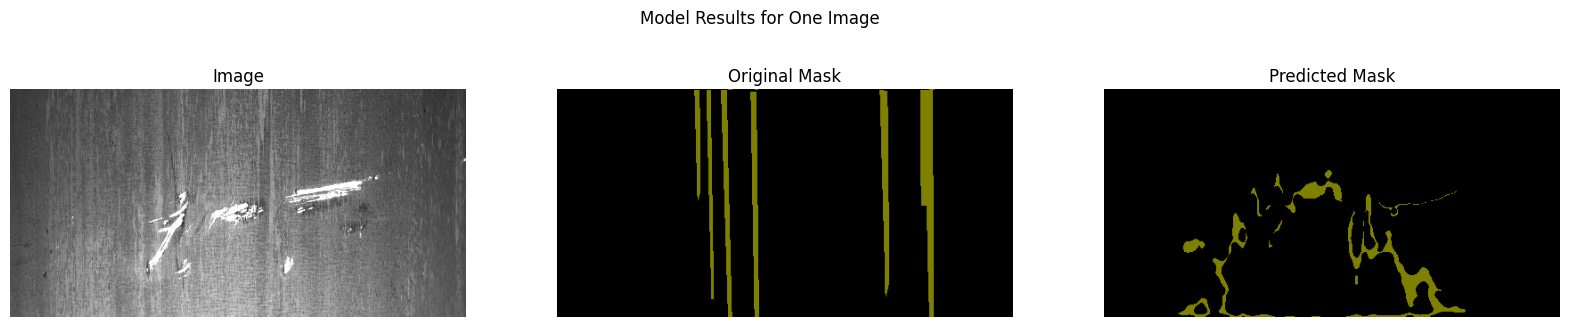

In [43]:
show_model_output(14, model)

# Links and References

Yadda yadda<a href="#note1" id="note1ref"><sup>1</sup></a>
italicized text

<b id="f1">1</b>  [Link 1](https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/)

<b id="f2">2</b>  [Link 2](https://www.v7labs.com/blog/image-segmentation-guide#h5)

<b id="f3">3</b> [Link 3](https://github.com/dhruvbird/ml-notebooks/blob/main/pets_segmentation/oxford-iiit-pets-segmentation-using-pytorch-segnet-and-depth-wise-separable-convs.ipynb)

